### Imports, Simulation Setup

In [46]:
import numpy as np 
import pandas as pd
from pulsee import simulation as sim, quantum_computing as qc, operators as op 
from pulsee.many_body import tensor_product

In [47]:
Iz = np.array([[1/2, 0],[0,-1/2]])
Iz = op.Operator(Iz)

In [48]:
SIM_NAME = "/test/11uncorrelated_mixed_no_interactions"

### Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 4.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 10$ T:

In [49]:
CORRELATED = True
MIXED = True
QUANTUM_NUMBERS = [1.5, 0.5] 
GAMMA_2PIS = [4.00, 0] 
B_0 = 10
# one control qubit (cnotnot) or two control qubits (toffoli)
CNOT_GATE = qc.toffoli 

zeem_par = {'field magnitude' : B_0,
                'theta_z' : 0,
                'phi_z' : 0}

### Pulse
Set up single mode pulse of form 
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively. $B_1$ in T, $\nu$ in MHz, $\delta$, $\phi$, and $\theta$ in radians. TODO: $\nu$ depends on $e^2 q Q $ and $\eta$? What is $\eta$? Why?

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 100 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$.

In [50]:
B_1 = B_0 / 100
FREQ = GAMMA_2PIS[0] * B_0
PHASE = 0
POLAR_B = np.pi / 2 
AZIMUTHAL_B = 0 
PULSE_TIME = 1 / (4 * FREQ)
mode = pd.DataFrame([(FREQ, 2 * B_1, PHASE, POLAR_B, AZIMUTHAL_B)],
					columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

### Experiment Settings

In [51]:
ACQUISITION_TIME = 1000 # in microseconds
T2 = 100

### Hamiltonians
Here we add the desired Hamiltonian interaction terms. Add these to the following dictionary `args` with key as it appears in `nuclear_system_setup` function. The value should be the parameters of the associated Hamiltonian as it appears in `nuclear_system_setup`.

In [52]:
h_dict = {
}

### Density Matrix Setup 
If `CORRELATED` start with qubit $\ket{111}$ so that in the case of 
Toffoli (CCNOT) the second control qubit leads to negation of last qubit. 
Before applying CCNOT or CNOTNOT apply Hadamard to first qubit to create 
superposition. 

In [53]:
args = h_dict.copy()
spin_par = []
for qn, gam in zip(QUANTUM_NUMBERS, GAMMA_2PIS):
    spin_par.append({'quantum number': qn, 'gamma/2pi': gam})

args['spin_par'] = spin_par 
args['zeem_par'] = zeem_par
spin, h_unperturbed, _ = sim.nuclear_system_setup(**args)

qs = qc.CompositeQubitSpace(3)

# Construct the tensor product of the Hadamard gate and 2 identity operators
had_id = qc.gate_tensor_product(qc.hadamard, qc.gate_tensor_pow(qc.identity, 2))

corr_operator = CNOT_GATE * had_id


if CORRELATED and MIXED: 
    state = op.canonical_density_matrix(h_unperturbed, 1e-4).matrix
    print(state)
    corr = had_id.matrix @ state @ qc.adjoint(had_id.matrix)

    initial_dm_matrix = corr
    
elif MIXED: 
    initial_dm_matrix = op.canonical_density_matrix(h_unperturbed, 1e-4).matrix
    
elif CORRELATED: 
    # Use state ket |111⟩
    q = qs.basis_ket_from_indices([0, 0, 0])

    # Create entanglement 
    corr_state = had_id(q)
    initial_dm = corr_state.density_matrix
    initial_dm_matrix = initial_dm.matrix

initial_dm = op.Operator(initial_dm_matrix)

print('H_unperturbed:')
print(np.round(h_unperturbed.matrix, 3))
print('Initial density matrix:')
print(np.round(initial_dm.matrix, 3))

[[4.99999998e-01+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 4.99999998e-01+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 2.30054571e-09+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  2.30054571e-09+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 1.05850211e-17+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 1.05850211e-17+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.0000

### Simulation

In [54]:
evolved_dm = sim.evolve(spin, h_unperturbed, initial_dm, 
						mode=mode, pulse_time=PULSE_TIME)

t, fid = sim.FID_signal(spin, h_unperturbed, evolved_dm, 
						acquisition_time=ACQUISITION_TIME, T2=T2)
						
f, ft = sim.fourier_transform_signal(t, fid, -1, 1)

Write simulation parameters and save plots to a directory. 

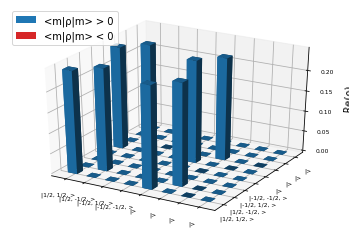

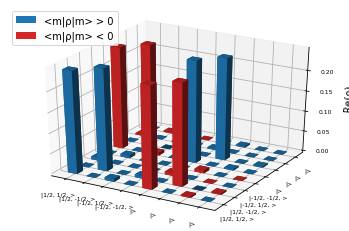

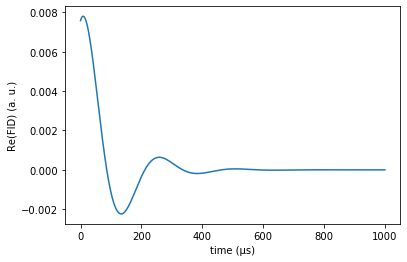

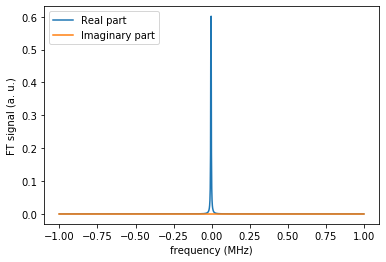

In [55]:
import os 
import json 
import shutil

sim_dir = None 
if SIM_NAME is not None: 
	sim_dir = f'./simulation_results/{SIM_NAME}/'
else:
	i = 1
	while os.path.isdir(f'./simulation_results/sim_{i:04d}'):
		i += 1

	sim_dir = f'./simulation_results/sim_{i:04d}/'

if os.path.isdir(sim_dir):
	shutil.rmtree(sim_dir)

os.mkdir(sim_dir)

# numpy ndarray can't be json serialized
if 'h_tensor_inter' in h_dict.keys(): 
	h_dict['h_tensor_inter'] = h_dict['h_tensor_inter'].tolist()

params = {
	'correlated_state': CORRELATED, 
	'mixed': MIXED, 
	'quantum_numbers': QUANTUM_NUMBERS, 
	'gamma_2pis': GAMMA_2PIS, 
	'B_0': B_0,
	'pulse_params': {
		'amplitude': 2 * B_1, 
		'frequency': FREQ, 
		'phase': PHASE, 
		'theta_p': POLAR_B, 
		'phi_p': AZIMUTHAL_B, 
		'pulse_time': PULSE_TIME
	},
	'acquisition_time': ACQUISITION_TIME, 
	't2': T2,
	'hamiltonian_args': h_dict
}

params_file = open(os.path.join(sim_dir, 'params.json'), 'w')
json.dump(params, params_file, indent=4, separators=(',', ': '))
params_file.close()
 
np.savetxt(os.path.join(sim_dir, 'initial_dm.csv'),
		   initial_dm.matrix)

np.savetxt(os.path.join(sim_dir, 'evolved_dm.csv'),
		   evolved_dm.matrix)

np.savetxt(os.path.join(sim_dir, 't_fid_data.csv'), 
		   np.transpose(np.array([t, fid])),
		   delimiter=',', 
		   header='t,fid')
		   
np.savetxt(os.path.join(sim_dir, 'f_ft_data.csv'),
		   np.transpose(np.array([f, ft])),
		   delimiter=',',
		   header='f,ft')

sim.plot_real_part_density_matrix(initial_dm, 
								  save=True, 
								  destination=sim_dir,
								  name="InitialRealPartDensityMatrix",
								  many_spin_indexing=[2, 2])
sim.plot_real_part_density_matrix(evolved_dm,
								  save=True, 
								  destination=sim_dir,
								  name="EvolvedRealPartDensityMatrix", 
								  many_spin_indexing=[2, 2])
sim.plot_real_part_FID_signal(t, fid, save=True, destination=sim_dir)
_ = sim.plot_fourier_transform(f, np.abs(ft) ** 2, save=True, destination=sim_dir)
